In [1]:
!pip install pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lit

# Initialize a Spark session
spark = SparkSession.builder.appName("AmazonSalesAnalysis").getOrCreate()

# Load the CSV dataset
file_path = "/content/Amazon Sale Report.csv"
df = spark.read.csv(file_path, header=True, inferSchema=True)

# Display basic information about the dataset
df.show(5)  # Display the first 5 rows
df.printSchema()  # Display the schema

# Summary statistics using describe()
describe_summary = df.describe()
describe_summary.show()

# Basic information about the dataset using .info() equivalent
num_rows = df.count()
num_columns = len(df.columns)
print("Number of rows:", num_rows)
print("Number of columns:", num_columns)

# Display column names
column_names = df.columns
print("Column names:", column_names)

# Count null values in each column and calculate null percentages
null_percentages_exprs = [
    (col(col_name).isNull().cast("int") / lit(num_rows)).alias(f"{col_name}_null_percent")
    for col_name in df.columns
]
null_percentages = df.select(*null_percentages_exprs, "*")
null_percentages.show()




+-----+-------------------+--------+--------------------+----------+--------------+------------------+-------+---------------+-------------+----+----------+--------------+---+--------+------+-----------+-----------+----------------+------------+--------------------+-----+------------+-----------+
|index|           Order ID|    Date|              Status|Fulfilment|Sales Channel |ship-service-level|  Style|            SKU|     Category|Size|      ASIN|Courier Status|Qty|currency|Amount|  ship-city| ship-state|ship-postal-code|ship-country|       promotion-ids|  B2B|fulfilled-by|Unnamed: 22|
+-----+-------------------+--------+--------------------+----------+--------------+------------------+-------+---------------+-------------+----+----------+--------------+---+--------+------+-----------+-----------+----------------+------------+--------------------+-----+------------+-----------+
|    0|405-8078784-5731545|04-30-22|           Cancelled|  Merchant|     Amazon.in|          Standard| SET

In [2]:
# Drop irrelevant columns
irrelevant_columns = [
    "Order ID", "Style", "SKU", "ASIN", "currency",
    "ship-postal-code", "ship-country", "fulfilled-by", "Unnamed: 22", "Sales Channel","promotion-ids","'index'"
]
df = df.drop(*irrelevant_columns)

In [3]:
# Find unique values and count in each column
for col_name in df.columns:
    unique_values_count = df.groupBy(col_name).count()
    print(f"Unique values and their count in column '{col_name}':")
    unique_values_count.show(truncate=False)

Unique values and their count in column 'index':
+-----+-----+
|index|count|
+-----+-----+
|148  |1    |
|463  |1    |
|471  |1    |
|496  |1    |
|833  |1    |
|1088 |1    |
|1238 |1    |
|1342 |1    |
|1580 |1    |
|1591 |1    |
|1645 |1    |
|1829 |1    |
|1959 |1    |
|2122 |1    |
|2142 |1    |
|2366 |1    |
|2659 |1    |
|2866 |1    |
|3175 |1    |
|3749 |1    |
+-----+-----+
only showing top 20 rows

Unique values and their count in column 'Date':
+--------+-----+
|Date    |count|
+--------+-----+
|04-17-22|1604 |
|03-31-22|171  |
|05-16-22|1201 |
|04-25-22|1665 |
|04-18-22|1568 |
|04-13-22|1651 |
|05-29-22|1303 |
|05-23-22|1186 |
|04-05-22|1617 |
|04-08-22|1678 |
|05-19-22|1207 |
|04-06-22|1557 |
|04-21-22|1746 |
|04-02-22|1555 |
|05-30-22|1258 |
|04-24-22|1810 |
|05-27-22|1294 |
|04-19-22|1678 |
|04-23-22|1816 |
|04-04-22|1465 |
+--------+-----+
only showing top 20 rows

Unique values and their count in column 'Status':
+-----------------------------+-----+
|Status            

In [4]:
from pyspark.sql.functions import when,round
from pyspark.ml.feature import Imputer
# Fill null values in categorical columns with mode
categorical_columns = ["Status", "Fulfilment", "Category", "Size", "ship-city","Courier Status","Date","ship-state"]
for col_name in categorical_columns:
    mode_value = df.select(col(col_name)).groupBy(col_name).count().orderBy(col("count").desc()).first()[col_name]
    df = df.withColumn(col_name, when(col(col_name).isNull(), mode_value).otherwise(col(col_name)))

# Fill null values in numerical columns with mean
numerical_columns = ["Qty", "Amount"]
imputer = Imputer(inputCols=numerical_columns, outputCols=[f"{col}_imputed" for col in numerical_columns])
imputer_model = imputer.setStrategy("mean").fit(df)
df = imputer_model.transform(df)
# Round the "Amount_imputed" column to 2 decimal places
df = df.withColumn("Amount_imputed_rounded", round(col("Amount_imputed"), 2))


# Show the modified dataset with filled null values
df.show()

+-----+--------+--------------------+----------+--------------+------------------+-------------+----+--------------+---+------+-----------+--------------+-----+-----------+-----------------+----------------------+
|index|    Date|              Status|Fulfilment|Sales Channel |ship-service-level|     Category|Size|Courier Status|Qty|Amount|  ship-city|    ship-state|  B2B|Qty_imputed|   Amount_imputed|Amount_imputed_rounded|
+-----+--------+--------------------+----------+--------------+------------------+-------------+----+--------------+---+------+-----------+--------------+-----+-----------+-----------------+----------------------+
|    0|04-30-22|           Cancelled|  Merchant|     Amazon.in|          Standard|          Set|   S|       Shipped|  0|647.62|     MUMBAI|   MAHARASHTRA|false|          0|           647.62|                647.62|
|    1|04-30-22|Shipped - Deliver...|  Merchant|     Amazon.in|          Standard|        kurta| 3XL|       Shipped|  1| 406.0|  BENGALURU|     

In [5]:
from pyspark.sql.functions import sum
# Find null values in each column and calculate the count
null_counts = df.select(*[
    sum(col(col_name).isNull().cast("int")).alias(f"{col_name}_null_count")
    for col_name in df.columns
])

# Show the null counts
null_counts.show()

+----------------+---------------+-----------------+---------------------+-------------------------+-----------------------------+-------------------+---------------+-------------------------+--------------+-----------------+--------------------+---------------------+--------------+----------------------+-------------------------+---------------------------------+
|index_null_count|Date_null_count|Status_null_count|Fulfilment_null_count|Sales Channel _null_count|ship-service-level_null_count|Category_null_count|Size_null_count|Courier Status_null_count|Qty_null_count|Amount_null_count|ship-city_null_count|ship-state_null_count|B2B_null_count|Qty_imputed_null_count|Amount_imputed_null_count|Amount_imputed_rounded_null_count|
+----------------+---------------+-----------------+---------------------+-------------------------+-----------------------------+-------------------+---------------+-------------------------+--------------+-----------------+--------------------+--------------------

In [6]:
# Drop the columns "Qty", "Amount", and "Amount_imputed"
columns_to_drop = ["Qty", "Amount", "Amount_imputed"]
df = df.drop(*columns_to_drop)


In [7]:
from pyspark.sql.functions import col, to_date, dayofmonth, month, year

# Convert "Date" column to a proper timestamp format
df = df.withColumn("Date", to_date(col("Date"), "MM-dd-yy"))

# Extract day, month, and year from the "Date" column
df = df.withColumn("Day", dayofmonth(col("Date")))
df = df.withColumn("Month", month(col("Date")))
df = df.withColumn("Year", year(col("Date")))

# Show the updated DataFrame
df.show()



+-----+----------+--------------------+----------+--------------+------------------+-------------+----+--------------+-----------+--------------+-----+-----------+----------------------+---+-----+----+
|index|      Date|              Status|Fulfilment|Sales Channel |ship-service-level|     Category|Size|Courier Status|  ship-city|    ship-state|  B2B|Qty_imputed|Amount_imputed_rounded|Day|Month|Year|
+-----+----------+--------------------+----------+--------------+------------------+-------------+----+--------------+-----------+--------------+-----+-----------+----------------------+---+-----+----+
|    0|2022-04-30|           Cancelled|  Merchant|     Amazon.in|          Standard|          Set|   S|       Shipped|     MUMBAI|   MAHARASHTRA|false|          0|                647.62| 30|    4|2022|
|    1|2022-04-30|Shipped - Deliver...|  Merchant|     Amazon.in|          Standard|        kurta| 3XL|       Shipped|  BENGALURU|     KARNATAKA|false|          1|                 406.0| 30|  

In [8]:
# Data types of columns
for col_name, col_type in df.dtypes:
    print(f"Column '{col_name}' has data type '{col_type}'")

# Show the schema
df.printSchema()

Column 'index' has data type 'int'
Column 'Date' has data type 'date'
Column 'Status' has data type 'string'
Column 'Fulfilment' has data type 'string'
Column 'Sales Channel ' has data type 'string'
Column 'ship-service-level' has data type 'string'
Column 'Category' has data type 'string'
Column 'Size' has data type 'string'
Column 'Courier Status' has data type 'string'
Column 'ship-city' has data type 'string'
Column 'ship-state' has data type 'string'
Column 'B2B' has data type 'boolean'
Column 'Qty_imputed' has data type 'int'
Column 'Amount_imputed_rounded' has data type 'double'
Column 'Day' has data type 'int'
Column 'Month' has data type 'int'
Column 'Year' has data type 'int'
root
 |-- index: integer (nullable = true)
 |-- Date: date (nullable = true)
 |-- Status: string (nullable = true)
 |-- Fulfilment: string (nullable = true)
 |-- Sales Channel : string (nullable = true)
 |-- ship-service-level: string (nullable = true)
 |-- Category: string (nullable = true)
 |-- Size: s

In [9]:
from pyspark.sql.functions import sum
# Find null values in each column and calculate the count
null_counts = df.select(*[
    sum(col(col_name).isNull().cast("int")).alias(f"{col_name}_null_count")
    for col_name in df.columns
])

# Show the null counts
null_counts.show()

+----------------+---------------+-----------------+---------------------+-------------------------+-----------------------------+-------------------+---------------+-------------------------+--------------------+---------------------+--------------+----------------------+---------------------------------+--------------+----------------+---------------+
|index_null_count|Date_null_count|Status_null_count|Fulfilment_null_count|Sales Channel _null_count|ship-service-level_null_count|Category_null_count|Size_null_count|Courier Status_null_count|ship-city_null_count|ship-state_null_count|B2B_null_count|Qty_imputed_null_count|Amount_imputed_rounded_null_count|Day_null_count|Month_null_count|Year_null_count|
+----------------+---------------+-----------------+---------------------+-------------------------+-----------------------------+-------------------+---------------+-------------------------+--------------------+---------------------+--------------+----------------------+---------------

In [12]:
#Drop Date, Day and Year(year has only one value2022)

In [13]:
df=df.drop("Date","Day","Year")

In [14]:
from pyspark.sql.functions import col

# Find unique values and count in each column
for col_name in df.columns:
    unique_values_count = df.groupBy(col_name).count()
    print(f"Unique values and their count in column '{col_name}':")
    unique_values_count.show(truncate=False)


Unique values and their count in column 'index':
+-----+-----+
|index|count|
+-----+-----+
|148  |1    |
|463  |1    |
|471  |1    |
|496  |1    |
|833  |1    |
|1088 |1    |
|1238 |1    |
|1342 |1    |
|1580 |1    |
|1591 |1    |
|1645 |1    |
|1829 |1    |
|1959 |1    |
|2122 |1    |
|2142 |1    |
|2366 |1    |
|2659 |1    |
|2866 |1    |
|3175 |1    |
|3749 |1    |
+-----+-----+
only showing top 20 rows

Unique values and their count in column 'Status':
+-----------------------------+-----+
|Status                       |count|
+-----------------------------+-----+
|Shipped                      |77804|
|Shipped - Lost in Transit    |5    |
|Shipped - Delivered to Buyer |28769|
|Shipped - Returning to Seller|145  |
|Shipped - Rejected by Buyer  |11   |
|Cancelled                    |18332|
|Shipped - Returned to Seller |1953 |
|Shipped - Picked Up          |973  |
|Pending                      |658  |
|Shipped - Out for Delivery   |35   |
|Pending - Waiting for Pick Up|281  |
|Shippe

In [15]:
df=df.drop("Month_null_count_filled")

ANALYSIS

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline

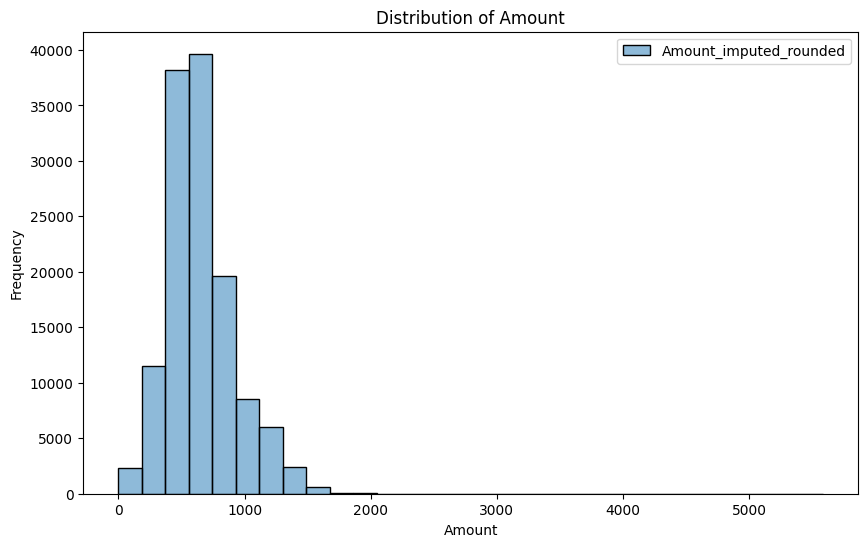

In [19]:
# Univariate Analysis
# Example: Plot a histogram of 'Amount_imputed_rounded'
plt.figure(figsize=(10, 6))
sns.histplot(df.select('Amount_imputed_rounded').toPandas(), bins=30)
plt.title('Distribution of Amount')
plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.show()

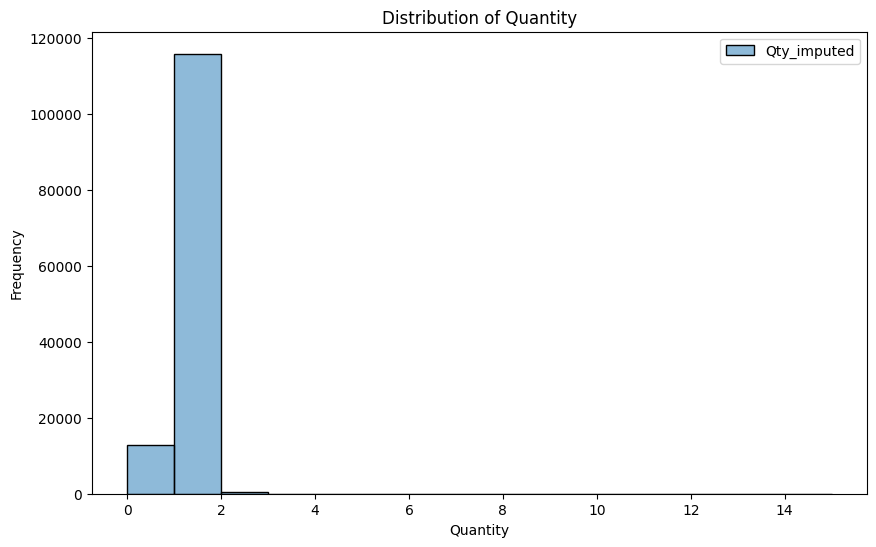

In [22]:
plt.figure(figsize=(10, 6))
sns.histplot(df.select('Qty_imputed').toPandas(), bins=15)
plt.title('Distribution of Quantity')
plt.xlabel('Quantity')
plt.ylabel('Frequency')
plt.show()

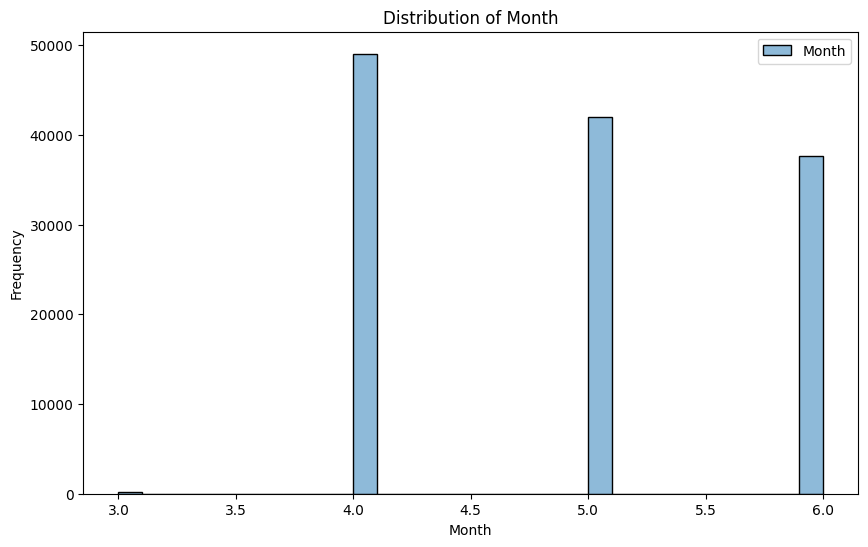

In [24]:
plt.figure(figsize=(10, 6))
sns.histplot(df.select('Month').toPandas(), bins=30)
plt.title('Distribution of Month')
plt.xlabel('Month')
plt.ylabel('Frequency')
plt.show()

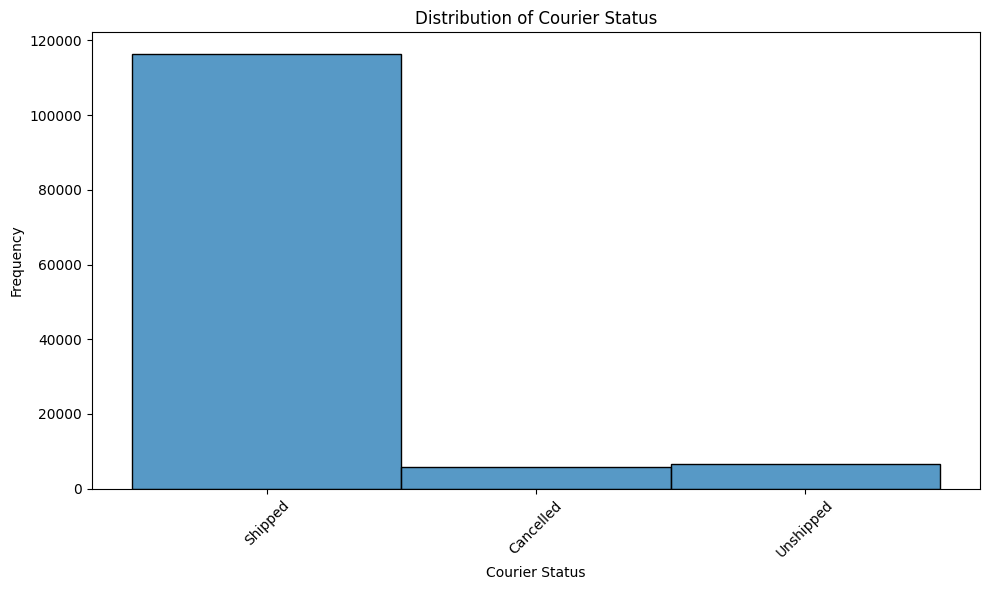

In [27]:
# Convert the Spark DataFrame to a Pandas DataFrame
pandas_df = df.select('Courier Status').toPandas()

# Plot the histogram using seaborn
plt.figure(figsize=(10, 6))
sns.histplot(pandas_df, x='Courier Status', bins=30)
plt.title('Distribution of Courier Status')
plt.xlabel('Courier Status')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

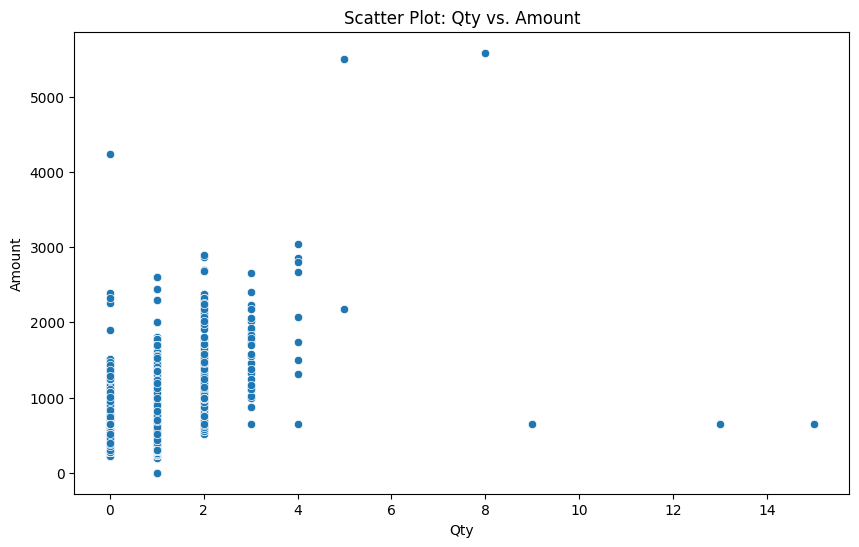

In [28]:
# Bivariate Analysis
# Create a scatter plot between 'Qty_imputed' and 'Amount_imputed_rounded'
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Qty_imputed', y='Amount_imputed_rounded', data=df.toPandas())
plt.title('Scatter Plot: Qty vs. Amount')
plt.xlabel('Qty')
plt.ylabel('Amount')
plt.show()

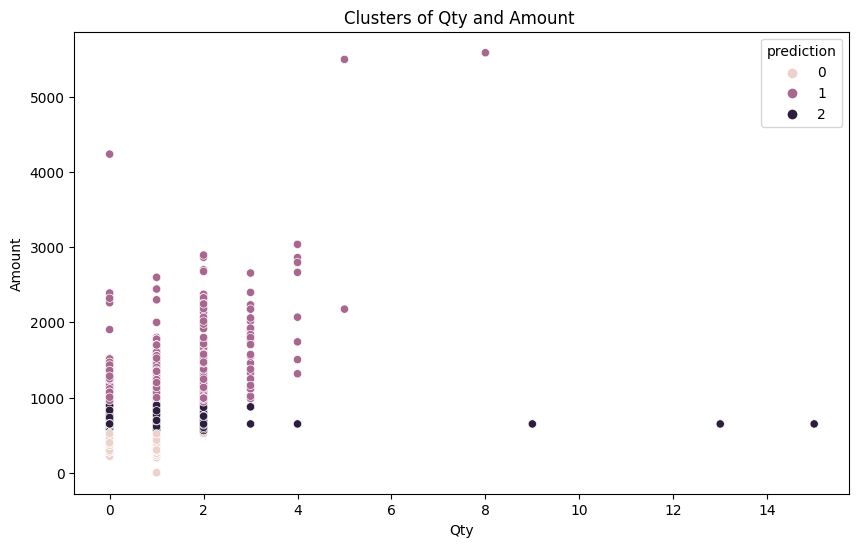

In [39]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans
from pyspark.ml import Pipeline

# Select feature columns for clustering
feature_cols = ['Qty_imputed', 'Amount_imputed_rounded']

# Create a VectorAssembler to combine features
assembler = VectorAssembler(inputCols=feature_cols, outputCol='features')

# Initialize KMeans with desired number of clusters
kmeans = KMeans().setK(3).setSeed(1)  # Number of clusters = 3

# Create a pipeline
pipeline = Pipeline(stages=[assembler, kmeans])

# Fit the model and transform the data
model = pipeline.fit(df)
clustered_data = model.transform(df)

# Visualize clusters
clustered_df = clustered_data.select('Qty_imputed', 'Amount_imputed_rounded', 'prediction').toPandas()


plt.figure(figsize=(10, 6))
sns.scatterplot(x='Qty_imputed', y='Amount_imputed_rounded', hue='prediction', data=clustered_df)
plt.title('Clusters of Qty and Amount ')
plt.xlabel('Qty')
plt.ylabel('Amount')
plt.show()


In [40]:
###The cluster 0 represents all Data points, were the amount is less thann 1000 and quantity is also below 1

In [41]:
###The cluster 1 represents all Data points, were the amount is above 500 and not exceeding 1000 and varies within quantities 0-15

In [42]:
###The cluster 2 represents all Data points, were the amount is above 1000 and quantity range between 0-6

ANALYSIS

In [43]:
#Which month has the largest number of cancellations and what is the count?

In [48]:
from pyspark.sql.functions import month, sum, col, to_date
from pyspark.sql import SparkSession

# Create a Spark session
spark = SparkSession.builder.appName("Analysis").getOrCreate()

# Convert 'Month' column to DATE data type
df = df.withColumn('Month', to_date(col('Month'), 'MM'))

# Set configuration to use the old datetime parser
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")

cancelled_by_month = df.filter(df['Status'] == 'Cancelled') \
                       .groupBy(month('Month')) \
                       .agg(sum('Qty_imputed').alias('Cancelled_Count')) \
                       .orderBy('Cancelled_Count', ascending=False)

cancelled_by_month.show(1)



+------------+---------------+
|month(Month)|Cancelled_Count|
+------------+---------------+
|           4|           2110|
+------------+---------------+
only showing top 1 row



In [49]:
## What is the distribution of order statuses?

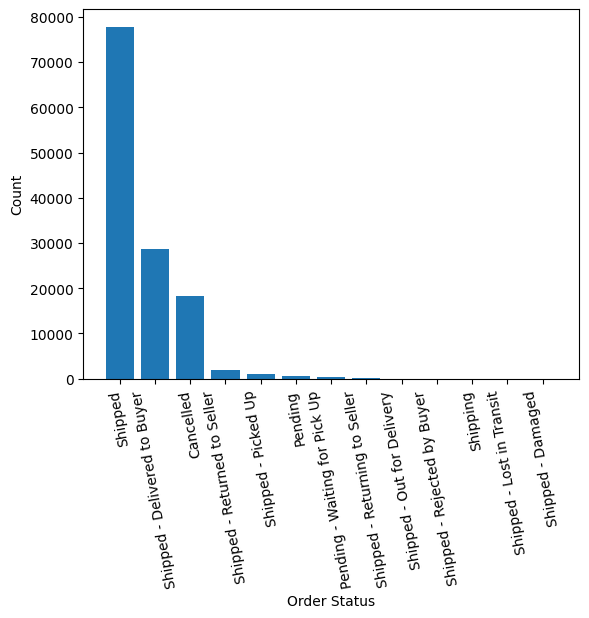

In [52]:
from pyspark.sql.functions import col
import matplotlib.pyplot as plt

status_distribution = df.groupBy('Status') \
                     .count() \
                     .orderBy('count', ascending=False)

status_distribution_pd = status_distribution.toPandas()
plt.bar(status_distribution_pd['Status'], status_distribution_pd['count'])
plt.xticks(rotation=100)
plt.xlabel('Order Status')
plt.ylabel('Count')
plt.show()


In [53]:
##How many orders were fulfilled by each fulfillment type?

In [54]:
fulfilment_counts = df.groupBy('Fulfilment') \
                    .count()

fulfilment_counts.show()


+----------+-----+
|Fulfilment|count|
+----------+-----+
|  Merchant|39277|
|    Amazon|89698|
+----------+-----+



In [55]:
##Which sales channel has the highest number of orders?

In [56]:
sales_channel_counts = df.groupBy('Sales Channel ') \
                      .count() \
                      .orderBy('count', ascending=False)

sales_channel_counts.show(1)


+--------------+------+
|Sales Channel | count|
+--------------+------+
|     Amazon.in|128851|
+--------------+------+
only showing top 1 row



In [57]:
##What is the distribution of ship service levels?

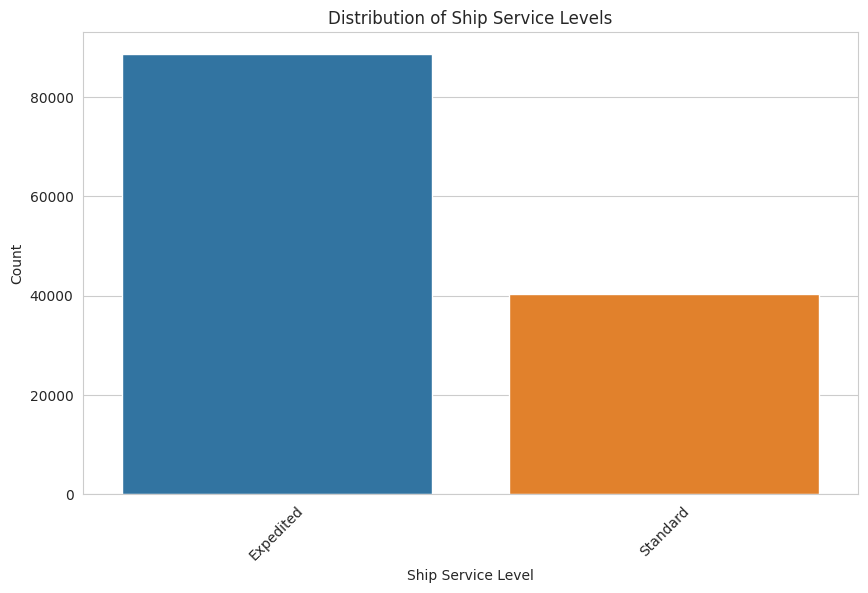

In [58]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")
ship_service_counts = df.groupBy('ship-service-level') \
                      .count() \
                      .orderBy('count', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='ship-service-level', y='count', data=ship_service_counts.toPandas())
plt.xticks(rotation=45)
plt.xlabel('Ship Service Level')
plt.ylabel('Count')
plt.title('Distribution of Ship Service Levels')
plt.show()


In [59]:
##What is the distribution of order categories?

In [60]:
category_counts = df.groupBy('Category') \
                  .count() \
                  .orderBy('count', ascending=False)

category_counts.show()


+-------------+-----+
|     Category|count|
+-------------+-----+
|          Set|50284|
|        kurta|49877|
|Western Dress|15500|
|          Top|10622|
| Ethnic Dress| 1159|
|       Blouse|  926|
|       Bottom|  440|
|        Saree|  164|
|      Dupatta|    3|
+-------------+-----+



In [61]:
##What is the distribution of order sizes?

In [62]:
size_counts = df.groupBy('Size') \
              .count() \
              .orderBy('count', ascending=False)

size_counts.show()


+----+-----+
|Size|count|
+----+-----+
|   M|22711|
|   L|22132|
|  XL|20876|
| XXL|18096|
|   S|17090|
| 3XL|14816|
|  XS|11161|
| 6XL|  738|
| 5XL|  550|
| 4XL|  427|
|Free|  378|
+----+-----+



In [63]:
##What is the distribution of courier statuses?

In [64]:
courier_status_counts = df.groupBy('Courier Status') \
                      .count() \
                      .orderBy('count', ascending=False)

courier_status_counts.show()


+--------------+------+
|Courier Status| count|
+--------------+------+
|       Shipped|116359|
|     Unshipped|  6681|
|     Cancelled|  5935|
+--------------+------+



In [65]:
##What is the distribution of months for orders?

In [66]:
month_counts = df.groupBy('Month') \
               .count() \
               .orderBy('count', ascending=False)

month_counts.show()


+----------+-----+
|     Month|count|
+----------+-----+
|1970-04-01|49067|
|1970-05-01|42040|
|1970-06-01|37697|
|1970-03-01|  171|
+----------+-----+



In [67]:
##What is the distribution of B2B orders?

In [68]:
b2b_counts = df.groupBy('B2B') \
            .count()

b2b_counts.show()


+-----+------+
|  B2B| count|
+-----+------+
| true|   871|
|false|128104|
+-----+------+



In [69]:
##Find the top 5 categories and their corresponding fulfillment modes (Merchant/Amazon) that have the highest number of cancellations.

In [70]:
cancelled_categories = df.filter(df['Status'] == 'Cancelled') \
                        .groupBy('Category', 'Fulfilment') \
                        .agg(sum('Qty_imputed').alias('Cancelled_Count')) \
                        .orderBy('Cancelled_Count', ascending=False)

cancelled_categories.show(5)


+-------------+----------+---------------+
|     Category|Fulfilment|Cancelled_Count|
+-------------+----------+---------------+
|          Set|    Amazon|           2256|
|        kurta|    Amazon|           2253|
|          Top|    Amazon|            535|
|Western Dress|    Amazon|            525|
| Ethnic Dress|    Amazon|             37|
+-------------+----------+---------------+
only showing top 5 rows



In [71]:
##Calculate the average order amount for Amazon orders (Fulfillment: Amazon) for each month.


In [75]:
from pyspark.sql.functions import avg, expr

average_amount_amazon = df.filter(df['Fulfilment'] == 'Amazon') \
                         .groupBy(expr('month(Month)')) \
                         .agg(avg('Amount_imputed_rounded').alias('Average_Amount_Amazon')) \
                         .orderBy(expr('month(Month)'))

average_amount_amazon.show()


+------------+---------------------+
|month(Month)|Average_Amount_Amazon|
+------------+---------------------+
|           3|    630.4124324324324|
|           4|    632.9823902849504|
|           5|    662.0303857981473|
|           6|    656.2479332032134|
+------------+---------------------+



In [76]:
##Determine the top 5 categories and their most common sizes (Size with the highest count) among all orders.

In [78]:
from pyspark.sql.functions import desc, row_number,count
from pyspark.sql.window import Window

common_sizes = df.groupBy('Category', 'Size') \
                 .agg(count('*').alias('Size_Count')) \
                 .withColumn('rn', row_number().over(Window.partitionBy('Category').orderBy(desc('Size_Count')))) \
                 .filter(col('rn') == 1) \
                 .select('Category', 'Size', 'Size_Count') \
                 .orderBy('Size_Count', ascending=False)

common_sizes.show(5)


+-------------+----+----------+
|     Category|Size|Size_Count|
+-------------+----+----------+
|          Set|   M|      9347|
|        kurta|   L|      8920|
|Western Dress|   L|      2845|
|          Top|  XL|      1855|
|       Blouse|Free|       211|
+-------------+----+----------+
only showing top 5 rows



In [79]:
#Plot a line chart that shows the monthly distribution of sales (number of orders) for different fulfillment modes (Merchant/Amazon).

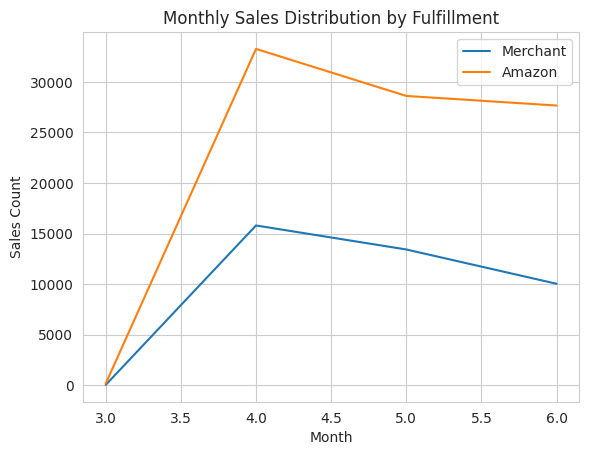

In [81]:
import matplotlib.pyplot as plt

monthly_sales_fulfillment = df.groupBy(expr('month(Month)'), 'Fulfilment') \
                              .agg(count('*').alias('Sales_Count')) \
                              .orderBy(expr('month(Month)'), 'Fulfilment')

fulfillment_names = monthly_sales_fulfillment.select('Fulfilment').distinct().rdd.flatMap(lambda x: x).collect()
for fulfillment in fulfillment_names:
    fulfillment_data = monthly_sales_fulfillment.filter(monthly_sales_fulfillment['Fulfilment'] == fulfillment).toPandas()
    plt.plot(fulfillment_data['month(Month)'], fulfillment_data['Sales_Count'], label=fulfillment)

plt.xlabel('Month')
plt.ylabel('Sales Count')
plt.title('Monthly Sales Distribution by Fulfillment')
plt.legend()
plt.show()


In [82]:
#Analyze how the count of cancelled orders varies each month and plot a line chart to visualize the trend.

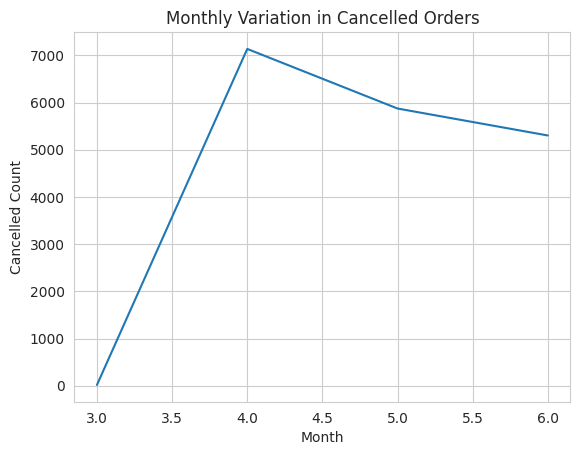

In [84]:
cancelled_orders_monthly = df.filter(df['Status'] == 'Cancelled') \
                            .groupBy(expr('month(Month)')) \
                            .agg(count('*').alias('Cancelled_Count')) \
                            .orderBy(expr('month(Month)'))

cancelled_orders_monthly_pd = cancelled_orders_monthly.toPandas()
plt.plot(cancelled_orders_monthly_pd['month(Month)'], cancelled_orders_monthly_pd['Cancelled_Count'])
plt.xlabel('Month')
plt.ylabel('Cancelled Count')
plt.title('Monthly Variation in Cancelled Orders')
plt.show()
